In [1]:
import tensorflow as tf
import numpy as np
import statistics
from libs import datasets, dataset_utils, utils
import datetime
from matplotlib import pyplot as plt
from scipy.signal import resample

In [2]:
%matplotlib notebook
plt.style.use('ggplot')
resources_dir = "/Users/alfonso/code/violinDemos/ViolinTrainer/resources/Scarlett_MyViolin/"
filenames = ['BackNoiseMaia', 'EString_Long', 'AString_Long', 'DString_Long', 'GString_Long']
#filenames = ['Silence01', 'EString01', 'AString01', 'DString01', 'GString01']
#filenames = ['Silence', 'EString', 'AString', 'DString', 'GString']
n_classes = 5
winLSecs = 0.1
energyBands_sr = 128

## First Model

In [5]:
#path params
path = './models/'
#model_name = 'string_convnet_scarlettGliss_20170417_1503' #string_convnet_20170414_0019' #string_convnet_20170413_2242'
model_name = 'string_convnet_scarlett_MyV_hop512_20170505_1039'
predictionOPStr = 'pred/activationOperationForOutput'  # 'pred/Sigmoid'

#load graph and variables
tf.reset_default_graph()
saver = tf.train.import_meta_graph(path + model_name + '.ckpt.meta')
graph = tf.get_default_graph()
session = tf.Session()
saver.restore(session, path + model_name + '.ckpt')

#get input, output and operation to run
net_input = graph.get_tensor_by_name('X:0')
predictionOP = graph.get_operation_by_name(predictionOPStr)
outputTensor = graph.get_tensor_by_name(predictionOPStr + ':0')
#accuracy = graph.get_operation_by_name('Mean_1')
windowSize = net_input.get_shape().as_list()[2]
windowSize

12

In [6]:
# load recorded analisys
iString=2
inputFile = resources_dir + filenames[iString] + '.16bit-EnergyBankFilter.txt'
#energy_bands = np.loadtxt(inputFile, skiprows=0).T
#energy_bands= (energy_bands /120 )+1 #normalize [0-1]
energy_bands_dB = np.loadtxt(inputFile, skiprows=0).T
print('inputFile:', inputFile)
energy_bands = 10**(energy_bands_dB/20)
rmsEnergy_dB=20*np.log10(np.sqrt(np.mean(energy_bands**2,0)))
energy_bands_norm= energy_bands_dB / rmsEnergy_dB
energy_bands_norm = energy_bands_norm /4
    
target = np.ones(energy_bands.shape[1]) * (iString)
hopSize=windowSize//2
n_hops = (energy_bands.shape[1]) // hopSize
n_hops = int(n_hops) - 1
Xs_i_test = []
ys_i_test = []
for hop_i in range(n_hops):
    frames=energy_bands_norm[:,(hop_i * hopSize):(hop_i * hopSize + windowSize)]
    avgString=round(statistics.median(target[(hop_i * hopSize):(hop_i * hopSize + windowSize)]))
    Xs_i_test.append(frames[..., np.newaxis])
    ys_i_test.append(int(avgString))
Xs_i_test = np.array(Xs_i_test)
ys_i_test = np.array(ys_i_test)
print("Xs_i_test.shape:", Xs_i_test.shape)

inputFile: /Users/alfonso/code/violinDemos/ViolinTrainer/resources/Scarlett_MyViolin/AString_Long.16bit-EnergyBankFilter.txt
Xs_i_test.shape: (1862, 40, 12, 1)


In [7]:
[ _, one_hot_prediction]=session.run([predictionOP, outputTensor], feed_dict={net_input:Xs_i_test})
prediction = np.argmax(one_hot_prediction, axis=1)
test_correct_prediction = prediction == ys_i_test
test_accuracy= np.mean(test_correct_prediction)
print("accuracy: ", test_accuracy)

accuracy:  0.929645542427


## Second model: melSpectrogram

In [8]:
from scipy.io.wavfile import write, read
import os
INT16_FAC = (2**15)-1
INT32_FAC = (2**31)-1
INT64_FAC = (2**63)-1
norm_fact = {'int16':INT16_FAC, 'int32':INT32_FAC, 'int64':INT64_FAC,'float32':1.0,'float64':1.0}


def wavread(filename):
	"""
	Read a sound file and convert it to a normalized floating point array
	filename: name of file to read
	returns fs: sampling rate of file, x: floating point array
	"""

	if (os.path.isfile(filename) == False):                  # raise error if wrong input file
		raise ValueError("Input file is wrong")

	fs, x = read(filename)

	if (len(x.shape) !=1):                                   # raise error if more than one channel
		raise ValueError("Audio file should be mono")

	if (fs !=44100):                                         # raise error if more than one channel
		raise ValueError("Sampling rate of input sound should be 44100")

	#scale down and convert audio into floating point number in range of -1 to 1
	x = np.float32(x)/norm_fact[x.dtype.name]
	return fs, x

In [9]:
#path params
path = './models/'
#model_name = 'string_convnet_scarlettGliss_20170417_1503' #string_convnet_20170414_0019' #string_convnet_20170413_2242'
model_name = 'string_convnet_MelSpec_fftS512_ffthop128_20170509_1814'
predictionOPStr = 'pred/activationOperationForOutput'  # 'pred/Sigmoid'

#load graph and variables
tf.reset_default_graph()
saver = tf.train.import_meta_graph(path + model_name + '.ckpt.meta')
graph = tf.get_default_graph()
session = tf.Session()
saver.restore(session, path + model_name + '.ckpt')

#get input, output and operation to run
net_input = graph.get_tensor_by_name('X:0')
predictionOP = graph.get_operation_by_name(predictionOPStr)
outputTensor = graph.get_tensor_by_name(predictionOPStr + ':0')
#accuracy = graph.get_operation_by_name('Mean_1')
windowSize = net_input.get_shape().as_list()[2]
windowSize

17

In [10]:
# Librosa for audio
import librosa

# load and Analyze recording
Xs_test = []
ys_test = []
convImgLengthSecs=0.05
#iRecording = 0 
#iString = 2
#inputFile = resources_dir + resource[iRecording] + "/" + filenames[iRecording][iString] + '.wav'
inputFile = resources_dir + filenames[iString] + '.wav'
(fs, x) = wavread(inputFile)
print(inputFile, ':', x.shape)
hopSize = 128
fftSize = 1024
analSR = fs / hopSize
convImgLength = int( analSR * convImgLengthSecs )
conv_hop = convImgLength //2

# Mel-scaled power (energy-squared) spectrogram
Sxx = librosa.feature.melspectrogram(x, sr=fs, n_mels=128, n_fft=fftSize, 
                                     hop_length=hopSize)
#n_fft=2048, hop_length=512,power=2.0,
# Convert to log scale (dB). We'll use the peak power as reference.
SxxdB = librosa.logamplitude(Sxx, ref_power=np.max)
auxavg = np.average(SxxdB, axis=0)
SxxdBNorm = SxxdB / auxavg

n_conv_hops = (SxxdB.shape[1]) // conv_hop
n_conv_hops = int(n_conv_hops) - 1        #??
for img_i in range(n_conv_hops):
    # Creating our sliding window
    frames = SxxdBNorm[:, (img_i * conv_hop):(img_i * conv_hop + convImgLength)]
    Xs_test.append(frames[..., np.newaxis])
    ys_test.append(iString)
Xs_test = np.array(Xs_test)
ys_test = np.array(ys_test)
print("Xs_test.shape:", np.array(Xs_test).shape, ", ys_test.shape:", np.array(ys_test).shape)
print("convImgLength:", convImgLength)

/Users/alfonso/anaconda/lib/python3.5/site-packages/scipy/io/wavfile.py:221: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


/Users/alfonso/code/violinDemos/ViolinTrainer/resources/Scarlett_MyViolin/AString_Long.wav : (11447296,)
Xs_test.shape: (11178, 128, 17, 1) , ys_test.shape: (11178,)
convImgLength: 17


In [11]:
[ _, one_hot_prediction2]=session.run([predictionOP, outputTensor], feed_dict={net_input:Xs_test})
prediction2 = np.argmax(one_hot_prediction2, axis=1)
test_correct_prediction2 = prediction2 == ys_test
test_accuracy2= np.mean(test_correct_prediction2)
print("accuracy: ", test_accuracy2)

accuracy:  0.981928788692


In [13]:
prediction2.shape[0]/prediction.shape[0]

6.003222341568207

## Plots

In [23]:
t=np.linspace(0,len(prediction2)-1,len(prediction))
plt.plot(prediction2)
plt.plot(t, prediction)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


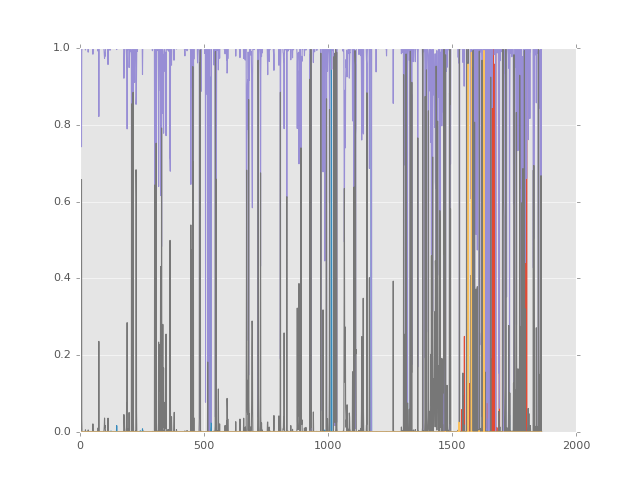

In [21]:
plt.plot(one_hot_prediction)